The good way to understand how the neural network learns a time series pattern without the extra noise and complexity of real financial data to approximate sinusoid.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

Now the Data generation, the number of points and the number of cycles to generate a sine wave.

In [8]:
N_POINTS = 1500
N_CYCLES = 10

# The number of past time steps to use as input to predict the next time step.
SEQUENCE_LENGTH = 50
TRAIN_RATIO = 0.70
VALIDATION_RATIO = 0.15

In [9]:
RESULTS_DIR = "sinusoid_ffnn_model_res"
EPOCHS = 25
BATCH_SIZE = 32

Generating sinusiud data, remove(comment if need for future use) noise from previous code.

In [13]:
print("--- Generating Sinusoid Data ---")
# Create a time vector
time = np.linspace(0, N_CYCLES * 2 * np.pi, N_POINTS)
# Generate the sine wave
sin_wave = np.sin(time)
#small amount of random noise to make it slightly more realistic
# noise = np.random.normal(0, 0.05, N_POINTS)
# sin_wave_noisy = sin_wave + noise
sin_wave_noisy = sin_wave

print(f"   Generated {N_POINTS} data points.")
# Return as a DataFrame
pd.DataFrame({'Value': sin_wave_noisy})

--- Generating Sinusoid Data ---
   Generated 1500 data points.


,Value
0,0.000000e+00
1,4.190357e-02
2,8.373353e-02
3,1.254164e-01
4,1.668790e-01
...,...
1495,-1.668790e-01
1496,-1.254164e-01
1497,-8.373353e-02
1498,-4.190357e-02


In [10]:
print("---Preparing Data for FFNN ---")

# Extract values and reshape for the scaler
values = sin_wave_noisy.reshape(-1, 1)

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)

# Create sequences
X, y = [], []
for i in range(len(scaled_data) - SEQUENCE_LENGTH):
    X.append(scaled_data[i:(i + SEQUENCE_LENGTH), 0])
    y.append(scaled_data[i + SEQUENCE_LENGTH, 0])
X, y = np.array(X), np.array(y)

# Split the data
train_size = int(len(X) * TRAIN_RATIO)
validation_size = int(len(X) * VALIDATION_RATIO)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size : train_size + validation_size], y[train_size : train_size + validation_size]
X_test, y_test = X[train_size + validation_size:], y[train_size + validation_size:]

print(f"   Training set size:   {len(X_train)} samples")
print(f"   Validation set size: {len(X_val)} samples")
print(f"   Test set size:       {len(X_test)} samples")

---Preparing Data for FFNN ---
   Training set size:   1014 samples
   Validation set size: 217 samples
   Test set size:       219 samples


In [14]:
print("--- Building, Training, and Evaluating Model ---")

model = Sequential([
  Input(shape=(SEQUENCE_LENGTH, 1)),
  Flatten(),
  Dense(64, activation='sigmoid'),
  Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

print("\n   Training the model...")
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1)

print("\n   Evaluating model performance...")
loss = model.evaluate(X_test, y_test)
print(f"   Test loss: {loss:.4f}")
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actuals to their original scale
predictions_actual = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("\n   Evaluating model performance...")
mae = mean_absolute_error(y_test_actual, predictions_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
print(f"   Mean Absolute Error (MAE): {mae:.4f}")
print(f"   Root Mean Squared Error (RMSE): {rmse:.4f}")

--- Building, Training, and Evaluating Model ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)


   Training the model...
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0491 - val_loss: 0.0017
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 1.3552e-04
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2954e-04 - val_loss: 6.8077e-05
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8655e-05 - val_loss: 6.0251e-05
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8193e-05 - val_loss: 4.9906e-05
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3190e-05 - val_loss: 4.4800e-05
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4090e-05 - val_loss: 3.5595e-05
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9972e-05 - val_loss: 3.8785e-05
Epoch 9/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2920e-05 - val_loss: 4.3852e-05
Epoch 10/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2235e-05 - val_loss: 1.9753e-05
Epoch 11/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9925

....  Generating plot to visualize approximation...


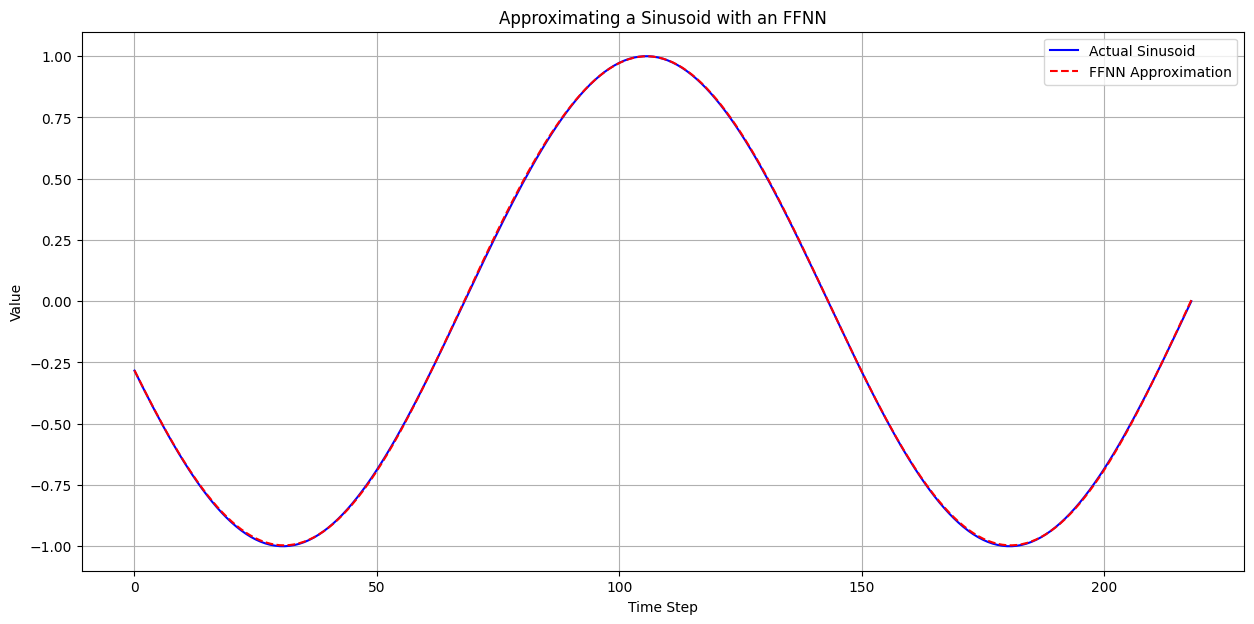

   Plot saved to 'sinusoid_ffnn_model_res/sinusoid_approximation.png'


In [15]:
print("....  Generating plot to visualize approximation...")
os.makedirs(RESULTS_DIR, exist_ok=True)
plot_path = os.path.join(RESULTS_DIR, 'sinusoid_approximation.png')

# Create an index for the x-axis of the plot
test_indices = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test_actual))

plt.figure(figsize=(15, 7))
plt.plot(y_test_actual, color='blue', label='Actual Sinusoid')
plt.plot(predictions_actual, color='red', linestyle='--', label='FFNN Approximation')
plt.title('Approximating a Sinusoid with an FFNN')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()
print(f"   Plot saved to '{plot_path}'")